In [11]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader,random_split
from torchvision import transforms
from torchinfo import summary 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from pytorchvideo.models.hub import i3d_r50

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchinfo import summary
import torch.optim as optim

In [2]:
DATASET_PATH = "/Users/pillisachethan/Desktop/DNN/project/UCF11_updated_mpg"
FRAME_COUNT = 16
IMG_SIZE = 224
BATCH_SIZE = 4
NUM_WORKERS = 0

In [3]:
# -------------------------------
# Dataset Loader
# -------------------------------
class VideoDataset(Dataset):
    def __init__(self, root_dir, class_names, transform=None):
        self.root_dir = root_dir
        self.class_names = class_names
        self.transform = transform
        self.video_paths = []
        self.labels = []

        for idx, class_name in enumerate(class_names):
            class_dir = os.path.join(root_dir, class_name)
            for subfolder in os.listdir(class_dir):
                subfolder_path = os.path.join(class_dir, subfolder)
                if not os.path.isdir(subfolder_path):
                    continue 
                for file_name in os.listdir(subfolder_path):
                    if file_name.endswith((".avi", ".mp4", ".mpg", ".mov")):
                        self.video_paths.append(os.path.join(subfolder_path, file_name))
                        self.labels.append(idx)

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        path = self.video_paths[idx]
        label = self.labels[idx]
        cap = cv2.VideoCapture(path)
        frames = []
        while len(frames) < FRAME_COUNT:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
            frame = frame[:, :, ::-1]  # BGR to RGB
            frames.append(frame)
        cap.release()

        while len(frames) < FRAME_COUNT:
            frames.append(frames[-1])

        frames = np.stack(frames, axis=0)
        frames = frames.transpose(3, 0, 1, 2)  # (C, T, H, W)
        frames = torch.tensor(frames, dtype=torch.float32) / 255.0
        return frames, label

In [4]:

# -------------------------------
# Get Class Names
# -------------------------------
CLASSES = []
for folder in sorted(os.listdir(DATASET_PATH)):
    folder_path = os.path.join(DATASET_PATH, folder)
    if os.path.isdir(folder_path):
        CLASSES.append(folder)


In [5]:

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15
train_dataset = VideoDataset(DATASET_PATH, CLASSES)

total_size = len(train_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size 
# Randomly split
train_data, val_data, test_data = random_split(train_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_data, batch_size=4, shuffle=False, num_workers=0)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False, num_workers=0)

In [6]:
import torch.nn as nn

class I3D_LSTM(nn.Module):
    def __init__(self, num_classes):
        super(I3D_LSTM, self).__init__()

        
        self.i3d = i3d_r50(pretrained=True)
        for param in self.i3d.parameters():
            param.requires_grad = True

        # LSTM
        self.lstm = nn.LSTM(input_size=1024, hidden_size=256, batch_first=True)

        self.batch_norm = nn.BatchNorm1d(256)
        self.fc = nn.Linear(256, 128)
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(128, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):  # x: (B, C, T, H, W)
        B = x.shape[0]
        for block in self.i3d.blocks[:-1]:
            x = block(x)  # Output: (B, 1024, T', 1, 1)

        x = x.view(B, 1024, -1).permute(0, 2, 1)  # (B, T', 1024)
        x, _ = self.lstm(x)                       # (B, T', 256)
        x = x[:, -1, :]                           # (B, 256)

        x = self.batch_norm(x)
        x = self.fc(x)
        x = self.relu(x)
        x = self.dropout(x)
        return self.classifier(x)

In [7]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = I3D_LSTM(num_classes=len(CLASSES)).to(device)

#  Model summary

info =summary(model, input_size=(1, 3, 16, 224, 224))
print(info)
# Loss function
criterion = nn.CrossEntropyLoss()

#  Optimizer with L2 regularization (applied to all trainable params)
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,
    weight_decay=5e-4  # L2 regularization
)

# LR scheduler (ReduceLROnPlateau)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Early stopping config
min_delta = 0.001
patience = 5
wait = 0
best_val_loss = float('inf')


train_accuracies, val_accuracies = [], []
train_losses, val_losses = [], []

# -------------------------------
# Training Loop
# -------------------------------
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    total, correct, loss_total = 0, 0, 0

    for videos, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        videos, labels = videos.to(device), labels.to(device)
        outputs = model(videos)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_total += loss.item() * videos.size(0)
        _, pred = torch.max(outputs, 1)
        correct += (pred == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss = loss_total / total
    train_accuracies.append(train_acc)
    train_losses.append(train_loss)

    # -------------------------------
    # Validation Loop
    # -------------------------------
    model.eval()
    val_total, val_correct, val_loss_total = 0, 0, 0

    with torch.no_grad():
        for videos, labels in val_loader:
            videos, labels = videos.to(device), labels.to(device)
            outputs = model(videos)
            loss = criterion(outputs, labels)

            val_loss_total += loss.item() * videos.size(0)
            _, pred = torch.max(outputs, 1)
            val_correct += (pred == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_loss = val_loss_total / val_total
    val_accuracies.append(val_acc)
    val_losses.append(val_loss)

    # 📊 Epoch Summary
    print(f"📊 Epoch {epoch+1} | LR: {optimizer.param_groups[0]['lr']:.6f} | "
          f"Train Acc: {train_acc:.4f}, Loss: {train_loss:.4f} | "
          f"Val Acc: {val_acc:.4f}, Loss: {val_loss:.4f}")

    # ✅ Scheduler Step
    scheduler.step(val_loss)

    # ✅ Early stopping
    if best_val_loss - val_loss < min_delta:
        wait += 1
        if wait >= patience:
            print(f"⛔️ Early stopping triggered at epoch {epoch+1}")
            break
    else:
        best_val_loss = val_loss
        wait = 0

/opt/anaconda3/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Layer (type:depth-idx)                                  Output Shape              Param #
I3D_LSTM                                                [1, 11]                   --
├─Net: 1-1                                              --                        --
│    └─ModuleList: 2-1                                  --                        819,600
│    │    └─ResNetBasicStem: 3-1                        [1, 64, 16, 56, 56]       47,168
│    │    └─ResStage: 3-2                               [1, 256, 16, 56, 56]      289,536
│    │    └─MaxPool3d: 3-3                              [1, 256, 8, 56, 56]       --
│    │    └─ResStage: 3-4                               [1, 512, 8, 28, 28]       1,416,192
│    │    └─ResStage: 3-5                               [1, 1024, 8, 14, 14]      8,409,088
│    │    └─ResStage: 3-6                               [1, 2048, 8, 7, 7]        17,061,888
├─LSTM: 1-2                                             [1, 784, 256]             1,312,768
├─BatchNorm1d: 1-

Epoch 1/30: 100%|█████████████████████████████| 280/280 [26:42<00:00,  5.72s/it]


📊 Epoch 1 | LR: 0.000100 | Train Acc: 0.2027, Loss: 2.2818 | Val Acc: 0.5083, Loss: 1.9819


Epoch 2/30: 100%|█████████████████████████████| 280/280 [25:38<00:00,  5.49s/it]


📊 Epoch 2 | LR: 0.000100 | Train Acc: 0.4473, Loss: 1.8566 | Val Acc: 0.6833, Loss: 1.3312


Epoch 3/30: 100%|█████████████████████████████| 280/280 [25:38<00:00,  5.49s/it]


📊 Epoch 3 | LR: 0.000100 | Train Acc: 0.6045, Loss: 1.4076 | Val Acc: 0.7333, Loss: 0.9709


Epoch 4/30: 100%|█████████████████████████████| 280/280 [26:01<00:00,  5.58s/it]


📊 Epoch 4 | LR: 0.000100 | Train Acc: 0.7393, Loss: 0.9907 | Val Acc: 0.8333, Loss: 0.6577


Epoch 5/30: 100%|█████████████████████████████| 280/280 [39:14<00:00,  8.41s/it]


📊 Epoch 5 | LR: 0.000100 | Train Acc: 0.8214, Loss: 0.7342 | Val Acc: 0.8458, Loss: 0.5386


Epoch 6/30: 100%|███████████████████████████| 280/280 [1:51:38<00:00, 23.92s/it]


📊 Epoch 6 | LR: 0.000100 | Train Acc: 0.8705, Loss: 0.5573 | Val Acc: 0.8917, Loss: 0.4569


Epoch 7/30: 100%|█████████████████████████████| 280/280 [28:01<00:00,  6.00s/it]


📊 Epoch 7 | LR: 0.000100 | Train Acc: 0.8982, Loss: 0.4228 | Val Acc: 0.8417, Loss: 0.5162


Epoch 8/30: 100%|█████████████████████████████| 280/280 [30:09<00:00,  6.46s/it]


📊 Epoch 8 | LR: 0.000100 | Train Acc: 0.9080, Loss: 0.4030 | Val Acc: 0.8250, Loss: 0.6507


Epoch 9/30: 100%|█████████████████████████████| 280/280 [30:15<00:00,  6.49s/it]


📊 Epoch 9 | LR: 0.000100 | Train Acc: 0.9286, Loss: 0.3360 | Val Acc: 0.9000, Loss: 0.3007


Epoch 10/30: 100%|████████████████████████████| 280/280 [31:20<00:00,  6.72s/it]


📊 Epoch 10 | LR: 0.000100 | Train Acc: 0.9473, Loss: 0.2895 | Val Acc: 0.8750, Loss: 0.4242


Epoch 11/30: 100%|████████████████████████████| 280/280 [31:43<00:00,  6.80s/it]


📊 Epoch 11 | LR: 0.000100 | Train Acc: 0.9589, Loss: 0.2093 | Val Acc: 0.8292, Loss: 0.6569


Epoch 12/30: 100%|████████████████████████████| 280/280 [30:44<00:00,  6.59s/it]


📊 Epoch 12 | LR: 0.000100 | Train Acc: 0.9634, Loss: 0.2082 | Val Acc: 0.8542, Loss: 0.5128


Epoch 13/30: 100%|████████████████████████████| 280/280 [29:18<00:00,  6.28s/it]


📊 Epoch 13 | LR: 0.000100 | Train Acc: 0.9286, Loss: 0.3485 | Val Acc: 0.8667, Loss: 0.4734


Epoch 14/30: 100%|████████████████████████████| 280/280 [26:45<00:00,  5.73s/it]


📊 Epoch 14 | LR: 0.000050 | Train Acc: 0.9696, Loss: 0.1622 | Val Acc: 0.9250, Loss: 0.3081
⛔️ Early stopping triggered at epoch 14


In [15]:
# -------------------------------
# Evaluation + Metrics
# -------------------------------
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for videos, labels in tqdm(test_loader):
        videos = videos.to(device)
        labels = labels.to(device)
        outputs = model(videos)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# 🔍 Metrics
print(f"Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%")
print("Precision:", precision_score(y_true, y_pred, average='weighted', zero_division=0))
print("Recall:", recall_score(y_true, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))

100%|███████████████████████████████████████████| 60/60 [01:45<00:00,  1.75s/it]

Accuracy: 92.08%
Precision: 0.9281410106777753
Recall: 0.9208333333333333
F1 Score: 0.9215122794936794


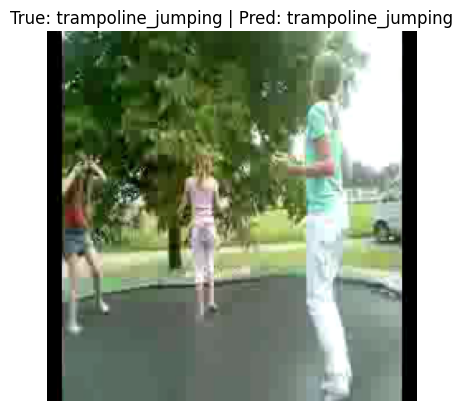

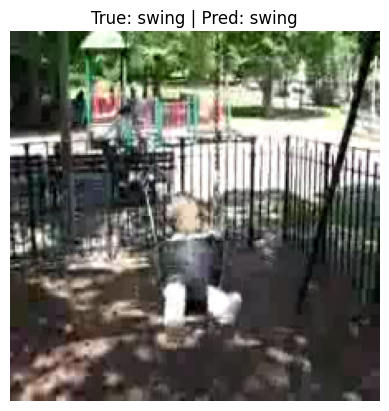

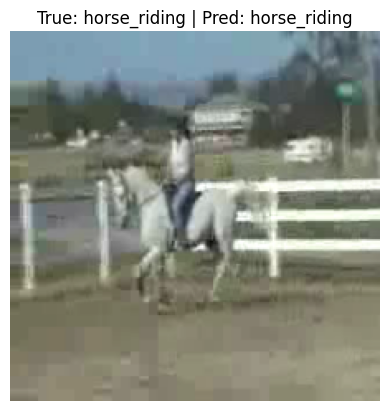

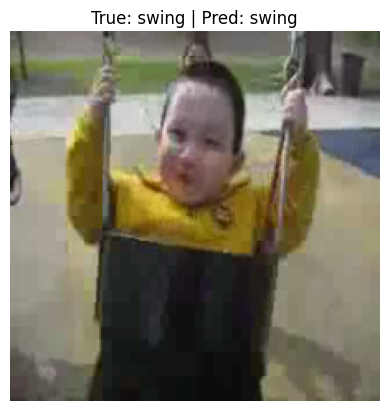

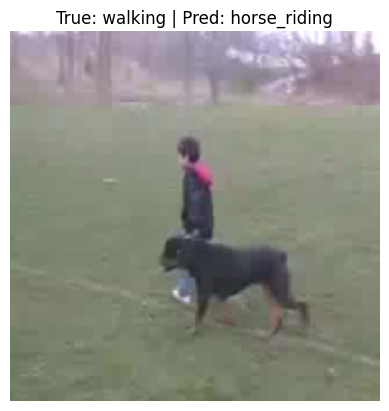

In [27]:
# Show 5 predictions from test set
model.eval()
for i in range(5):
    frames, label = test_data[i]  # test_data is a Subset
    frames = frames.unsqueeze(0).to(device)  # Add batch dim: (1, C, T, H, W)

    with torch.no_grad():
        output = model(frames)
        pred = torch.argmax(output, dim=1).item()

    # Convert first frame to displayable format
    frame_rgb = frames[0].permute(1, 2, 3, 0)[0].cpu().numpy()  # (H, W, C)

    # If normalized to 0–1, rescale to 0–255
    frame_rgb = (frame_rgb * 255).astype('uint8')

    plt.imshow(frame_rgb)
    plt.title(f"True: {CLASSES[label]} | Pred: {CLASSES[pred]}")
    plt.axis('off')
    plt.show()

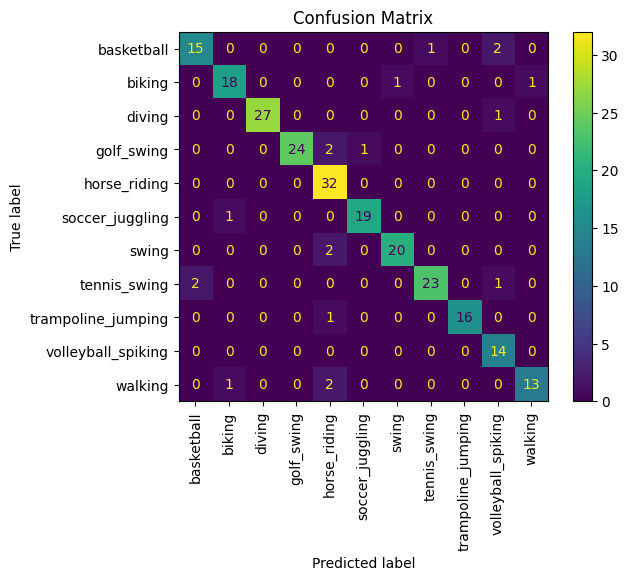

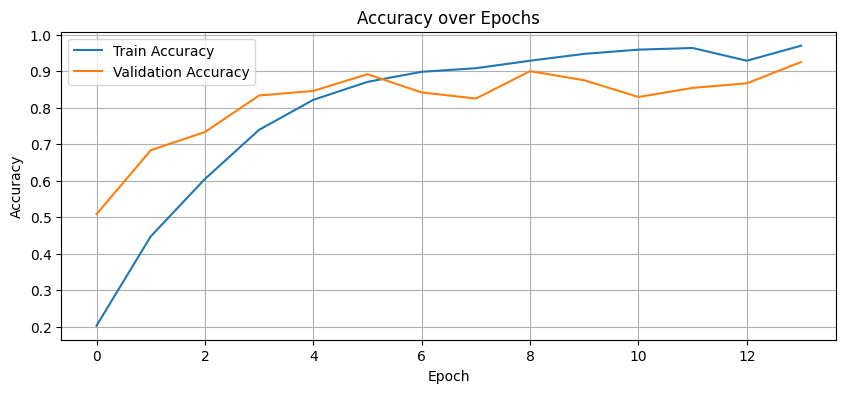

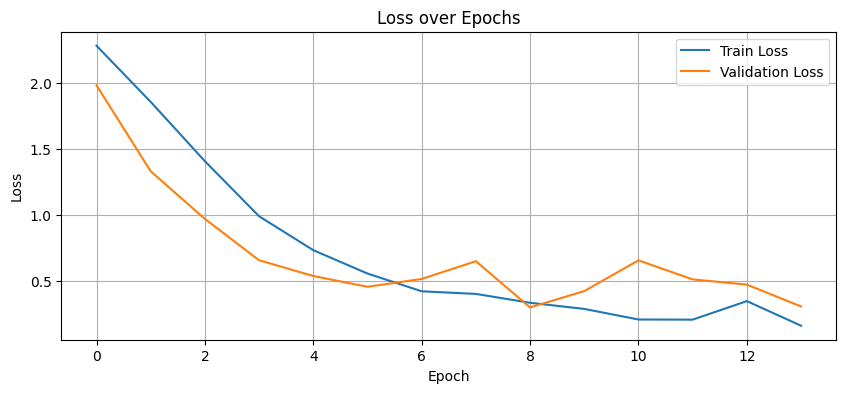

In [22]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
disp.plot(xticks_rotation=90)
plt.title("Confusion Matrix")
plt.show()

import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()